In [27]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = Path(PROJECT_PATH).parents[1] / 'data' / 'dunnhumby' / 'raw'

from data.dunnhumby.preprocess import load_transactions
from projects.segmentation_dunnhumby.src.features import (
    build_rfm_features,
    build_behavioral_features,
    build_category_features,
    build_time_features,
    build_all_features,
    MACRO_CATEGORY,
    FEATURE_COLS,
    ALL_FEATURE_COLS,
)

print('Project path:', PROJECT_PATH)
print('Data path:', DATA_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project path: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby
Data path: /Users/taehyun/project/side-projects/data/dunnhumby/raw


# Step 1: Feature Engineering

Build customer-level features for Factor Modeling & Clustering using `src/features.py`:
- **RFM Features** (19): Recency, Frequency, Monetary (multi-dimensional)
- **Behavioral Features** (7): Price sensitivity, brand preference, basket characteristics
- **Category Features** (6): Macro category spending shares
- **Time Features** (1): Shopping regularity

Total: **33 features** → Factor Modeling → Clustering

## Table of Contents

1. [Data Loading](#1.-Data-Loading)
2. [Feature Engineering](#2.-Feature-Engineering)
   - 2.1 [RFM Features](#2.1-RFM-Features)
   - 2.2 [Behavioral Features](#2.2-Behavioral-Features)
   - 2.3 [Category Features](#2.3-Category-Features)
   - 2.4 [Time Features](#2.4-Time-Features)
   - 2.5 [Build All Features](#2.5-Build-All-Features)
3. [Feature Analysis](#3.-Feature-Analysis)

## 1. Data Loading

In [28]:
# Load transaction data (with preprocessing)
df_trans = load_transactions(DATA_PATH)
print(f'Transactions: {len(df_trans):,}')

# Load product data
df_product = pd.read_csv(DATA_PATH / 'product.csv')
print(f'Products: {len(df_product):,}')

# Load demographic data
df_demo = pd.read_csv(DATA_PATH / 'hh_demographic.csv')
print(f'Households with demographics: {len(df_demo):,}')

Transactions: 2,581,260
Products: 92,353
Households with demographics: 801


In [29]:
# Basic info
print(f"Unique households: {df_trans['household_key'].nunique():,}")
print(f"Date range: Day {df_trans['DAY'].min()} - {df_trans['DAY'].max()}")
print(f"Week range: {df_trans['WEEK_NO'].min()} - {df_trans['WEEK_NO'].max()}")

Unique households: 2,500
Date range: Day 1 - 711
Week range: 1 - 102


## 2. Feature Engineering

Build customer-level features using `src/features.py` module. Each subsection demonstrates a feature builder function before combining them with `build_all_features()`.

### 2.1 RFM Features

**RFM (Recency, Frequency, Monetary)** analysis segments customers based on their purchase behavior:

| Group | Features | Description |
|-------|----------|-------------|
| **Recency** (6) | `recency`, `recency_weeks`, `active_last_4w`, `active_last_12w`, `days_between_purchases_avg/std` | How recently and how regularly customers purchase |
| **Frequency** (6) | `frequency`, `frequency_per_week/month`, `transaction_count`, `weeks_with_purchase`, `purchase_regularity` | How often customers purchase |
| **Monetary** (7) | `monetary_sales/actual`, `avg_basket_sales/actual`, `monetary_std`, `monetary_per_week`, `coupon_savings_ratio` | How much customers spend |

Also includes `tenure` and `tenure_weeks` (auxiliary columns for calculations).

In [30]:
# Build RFM features
df_rfm = build_rfm_features(df_trans)

print(f"RFM features: {df_rfm.shape[1] - 1} columns (excluding household_key)")
print(f"Columns: {list(df_rfm.columns)}")
df_rfm.head()

RFM features: 21 columns (excluding household_key)
Columns: ['household_key', 'recency', 'recency_weeks', 'active_last_4w', 'active_last_12w', 'days_between_purchases_avg', 'days_between_purchases_std', 'frequency', 'frequency_per_week', 'frequency_per_month', 'transaction_count', 'weeks_with_purchase', 'purchase_regularity', 'monetary_sales', 'monetary_actual', 'monetary_avg_basket_sales', 'monetary_avg_basket_actual', 'monetary_std', 'monetary_per_week', 'coupon_savings_ratio', 'tenure', 'tenure_weeks']


,household_key,recency,recency_weeks,active_last_4w,active_last_12w,days_between_purchases_avg,days_between_purchases_std,frequency,frequency_per_week,frequency_per_month,...,purchase_regularity,monetary_sales,monetary_actual,monetary_avg_basket_sales,monetary_avg_basket_actual,monetary_std,monetary_per_week,coupon_savings_ratio,tenure,tenure_weeks
0,1,5,0,1,1,8.506494,4.551647,85,0.894737,3.874211,...,0.715789,4330.16,4256.85,50.943059,50.080588,35.834565,45.580632,0.016930,660,95
1,2,43,6,0,1,12.840909,14.445734,45,0.511364,2.214205,...,0.397727,1954.34,1945.34,43.429778,43.229778,38.151384,22.208409,0.004605,608,88
2,3,8,1,1,1,13.111111,12.438689,47,0.546512,2.366395,...,0.430233,2653.21,2592.02,56.451277,55.149362,62.790677,30.851279,0.023063,598,86
3,4,84,12,0,1,18.034483,17.527285,30,0.344828,1.493103,...,0.298851,1200.11,1197.61,40.003667,39.920333,35.085380,13.794368,0.002083,607,87
4,5,8,1,1,1,19.312500,22.187324,40,0.444444,1.924444,...,0.300000,779.06,779.06,19.476500,19.476500,15.051558,8.656222,0.000000,626,90


### 2.2 Behavioral Features

Capture shopping behavior patterns beyond RFM:

| Feature | Description |
|---------|-------------|
| `discount_rate` | Total discount / shelf price ratio |
| `discount_usage_pct` | % of transactions with discounts |
| `private_label_ratio` | Private label purchases / total purchases |
| `n_departments` | Number of unique departments shopped |
| `n_products` | Number of unique products purchased |
| `avg_items_per_basket` | Average quantity per basket |
| `avg_products_per_basket` | Average unique products per basket |

In [31]:
# Build behavioral features
df_behavioral = build_behavioral_features(df_trans, df_product)

print(f"Behavioral features: {df_behavioral.shape[1] - 1} columns")
print(f"Columns: {list(df_behavioral.columns)}")
df_behavioral.head()

Behavioral features: 7 columns
Columns: ['household_key', 'discount_rate', 'discount_usage_pct', 'private_label_ratio', 'n_departments', 'n_products', 'avg_items_per_basket', 'avg_products_per_basket']


,household_key,discount_rate,discount_usage_pct,private_label_ratio,n_departments,n_products,avg_items_per_basket,avg_products_per_basket
0,1,0.151034,0.443860,0.118713,12,674,23.494118,7.929412
1,2,0.149670,0.458626,0.235624,12,545,18.533333,12.111111
2,3,0.217241,0.557003,0.187839,11,515,181.702128,10.957447
3,4,0.089626,0.433333,0.153333,9,164,12.733333,5.466667
4,5,0.131860,0.531532,0.216216,9,199,6.125000,4.975000


### 2.3 Category Features

Map 44 departments into 6 macro categories and compute spending share for each:

| Category | Departments |
|----------|-------------|
| `grocery` | GROCERY, FROZEN GROCERY, GRO BAKERY |
| `fresh` | PRODUCE, MEAT, MEAT-PCKGD, SEAFOOD, DELI, DAIRY DELI, etc. |
| `bakery` | PASTRY |
| `health_beauty` | DRUG GM, NUTRITION, COSMETICS, RX, HBC, etc. |
| `alcohol` | SPIRITS |
| `other` | Remaining departments |

Features: `share_grocery`, `share_fresh`, `share_bakery`, `share_health_beauty`, `share_alcohol`, `share_other`

In [32]:
# Show macro category mapping
print("Macro category mapping:")
for cat, depts in MACRO_CATEGORY.items():
    print(f"  {cat}: {depts}")

# Build category features
df_category = build_category_features(df_trans, df_product)

print(f"\nCategory features: {df_category.shape[1] - 1} columns")
df_category.head()

Macro category mapping:
  grocery: ['GROCERY', 'FROZEN GROCERY', 'GRO BAKERY']
  fresh: ['PRODUCE', 'MEAT', 'MEAT-PCKGD', 'MEAT-WHSE', 'PORK', 'SEAFOOD', 'SEAFOOD-PCKGD', 'DELI', 'DELI/SNACK BAR', 'DAIRY DELI', 'CHEF SHOPPE', 'SALAD BAR']
  bakery: ['PASTRY']
  health_beauty: ['DRUG GM', 'NUTRITION', 'COSMETICS', 'RX', 'PHARMACY SUPPLY', 'HBC']
  alcohol: ['SPIRITS']

Category features: 6 columns


,household_key,share_alcohol,share_bakery,share_fresh,share_grocery,share_health_beauty,share_other
0,1,0.0,0.022011,0.200563,0.636235,0.133764,0.007427
1,2,0.0,0.012700,0.220637,0.569241,0.183991,0.013432
2,3,0.0,0.001240,0.258114,0.672676,0.060429,0.007542
3,4,0.0,0.000000,0.147478,0.582222,0.270300,0.000000
4,5,0.0,0.003055,0.260558,0.460979,0.275409,0.000000


### 2.4 Time Features

Measure shopping consistency over time:

| Feature | Description |
|---------|-------------|
| `week_coverage` | (Active weeks) / (Tenure in weeks) — ratio of weeks with at least one purchase |

A high `week_coverage` indicates regular, consistent shopping behavior.

In [33]:
# Build time features
df_time = build_time_features(df_trans)

print(f"Time features: {df_time.shape[1] - 1} columns")
print(f"Columns: {list(df_time.columns)}")
df_time.head()

Time features: 1 columns
Columns: ['household_key', 'week_coverage']


,household_key,week_coverage
0,1,0.715789
1,2,0.426829
2,3,0.435294
3,4,0.346667
4,5,0.303371


### 2.5 Build All Features

The `build_all_features()` function orchestrates all 4 feature builders and merges them on `household_key`:

```python
def build_all_features(df_trans, df_product):
    df_rfm = build_rfm_features(df_trans)
    df_behavior = build_behavioral_features(df_trans, df_product)
    df_category = build_category_features(df_trans, df_product)
    df_time = build_time_features(df_trans)
    
    return df_rfm.merge(...).merge(...).merge(...)
```

This produces the complete **33-feature** customer matrix for downstream Factor Modeling and Clustering.

In [34]:
# Build all features using the orchestrator function
df_features = build_all_features(df_trans, df_product)

print(f"Feature matrix: {df_features.shape}")
print(f"\nFeature groups:")
for group, cols in FEATURE_COLS.items():
    print(f"  - {group}: {len(cols)} features")
print(f"\nTotal: {len(ALL_FEATURE_COLS)} features")

df_features.head()

Feature matrix: (2500, 36)

Feature groups:
  - recency: 6 features
  - frequency: 6 features
  - monetary: 7 features
  - behavioral: 7 features
  - category: 6 features
  - time: 1 features

Total: 33 features


,household_key,recency,recency_weeks,active_last_4w,active_last_12w,days_between_purchases_avg,days_between_purchases_std,frequency,frequency_per_week,frequency_per_month,...,n_products,avg_items_per_basket,avg_products_per_basket,share_alcohol,share_bakery,share_fresh,share_grocery,share_health_beauty,share_other,week_coverage
0,1,5,0,1,1,8.506494,4.551647,85,0.894737,3.874211,...,674,23.494118,7.929412,0.0,0.022011,0.200563,0.636235,0.133764,0.007427,0.715789
1,2,43,6,0,1,12.840909,14.445734,45,0.511364,2.214205,...,545,18.533333,12.111111,0.0,0.012700,0.220637,0.569241,0.183991,0.013432,0.426829
2,3,8,1,1,1,13.111111,12.438689,47,0.546512,2.366395,...,515,181.702128,10.957447,0.0,0.001240,0.258114,0.672676,0.060429,0.007542,0.435294
3,4,84,12,0,1,18.034483,17.527285,30,0.344828,1.493103,...,164,12.733333,5.466667,0.0,0.000000,0.147478,0.582222,0.270300,0.000000,0.346667
4,5,8,1,1,1,19.312500,22.187324,40,0.444444,1.924444,...,199,6.125000,4.975000,0.0,0.003055,0.260558,0.460979,0.275409,0.000000,0.303371


## 3. Feature Analysis

In [35]:
# Check for missing values and infinities
print("Missing values:")
print(df_features[ALL_FEATURE_COLS].isnull().sum()[df_features[ALL_FEATURE_COLS].isnull().sum() > 0])

print("\nInfinite values:")
inf_counts = np.isinf(df_features[ALL_FEATURE_COLS].select_dtypes(include=[np.number])).sum()
print(inf_counts[inf_counts > 0] if inf_counts.sum() > 0 else "None")

# Summary statistics
df_features[ALL_FEATURE_COLS].describe()

Missing values:
days_between_purchases_avg    3
days_between_purchases_std    3
monetary_std                  3
dtype: int64

Infinite values:
None


,recency,recency_weeks,active_last_4w,active_last_12w,days_between_purchases_avg,days_between_purchases_std,frequency,frequency_per_week,frequency_per_month,transaction_count,...,n_products,avg_items_per_basket,avg_products_per_basket,share_grocery,share_fresh,share_bakery,share_health_beauty,share_alcohol,share_other,week_coverage
count,2500.000000,2500.000000,2500.000000,2500.000000,2497.000000,2497.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,25.576000,3.419200,0.830800,0.930400,17.092829,19.385347,110.355600,1.188409,5.145809,1032.504000,...,558.067600,728.001253,6.502003,0.517840,0.242617,0.018663,0.147354,0.003158,0.070367,0.546905
std,62.791673,8.957386,0.375003,0.254523,28.245902,27.564067,115.433111,1.245894,5.394721,993.279847,...,434.335856,1241.327026,3.974498,0.118811,0.102666,0.028790,0.099641,0.020432,0.095097,0.267694
min,0.000000,0.000000,0.000000,0.000000,1.248077,0.000000,1.000000,0.010870,0.047065,4.000000,...,4.000000,1.593750,0.227545,0.024805,0.000000,0.000000,0.000000,0.000000,0.000000,0.023529
25%,1.000000,0.000000,1.000000,1.000000,5.214286,4.735325,38.000000,0.411765,1.782941,321.000000,...,230.000000,13.527193,3.864408,0.445346,0.173703,0.004884,0.076673,0.000000,0.005625,0.318681
50%,6.000000,1.000000,1.000000,1.000000,9.176471,9.893022,78.000000,0.834249,3.612299,730.000000,...,453.000000,137.506603,5.621966,0.524155,0.234742,0.012138,0.126055,0.000000,0.029451,0.550562
75%,20.000000,3.000000,1.000000,1.000000,18.212121,22.386901,142.000000,1.527345,6.613405,1445.500000,...,784.000000,965.912690,8.177667,0.593156,0.299906,0.023160,0.189012,0.000000,0.107362,0.779070
max,657.000000,94.000000,1.000000,1.000000,589.000000,326.500000,1298.000000,14.263736,61.761978,6775.000000,...,3144.000000,16322.500000,51.200000,1.000000,0.838235,0.600095,0.854558,0.688992,0.962214,1.000000


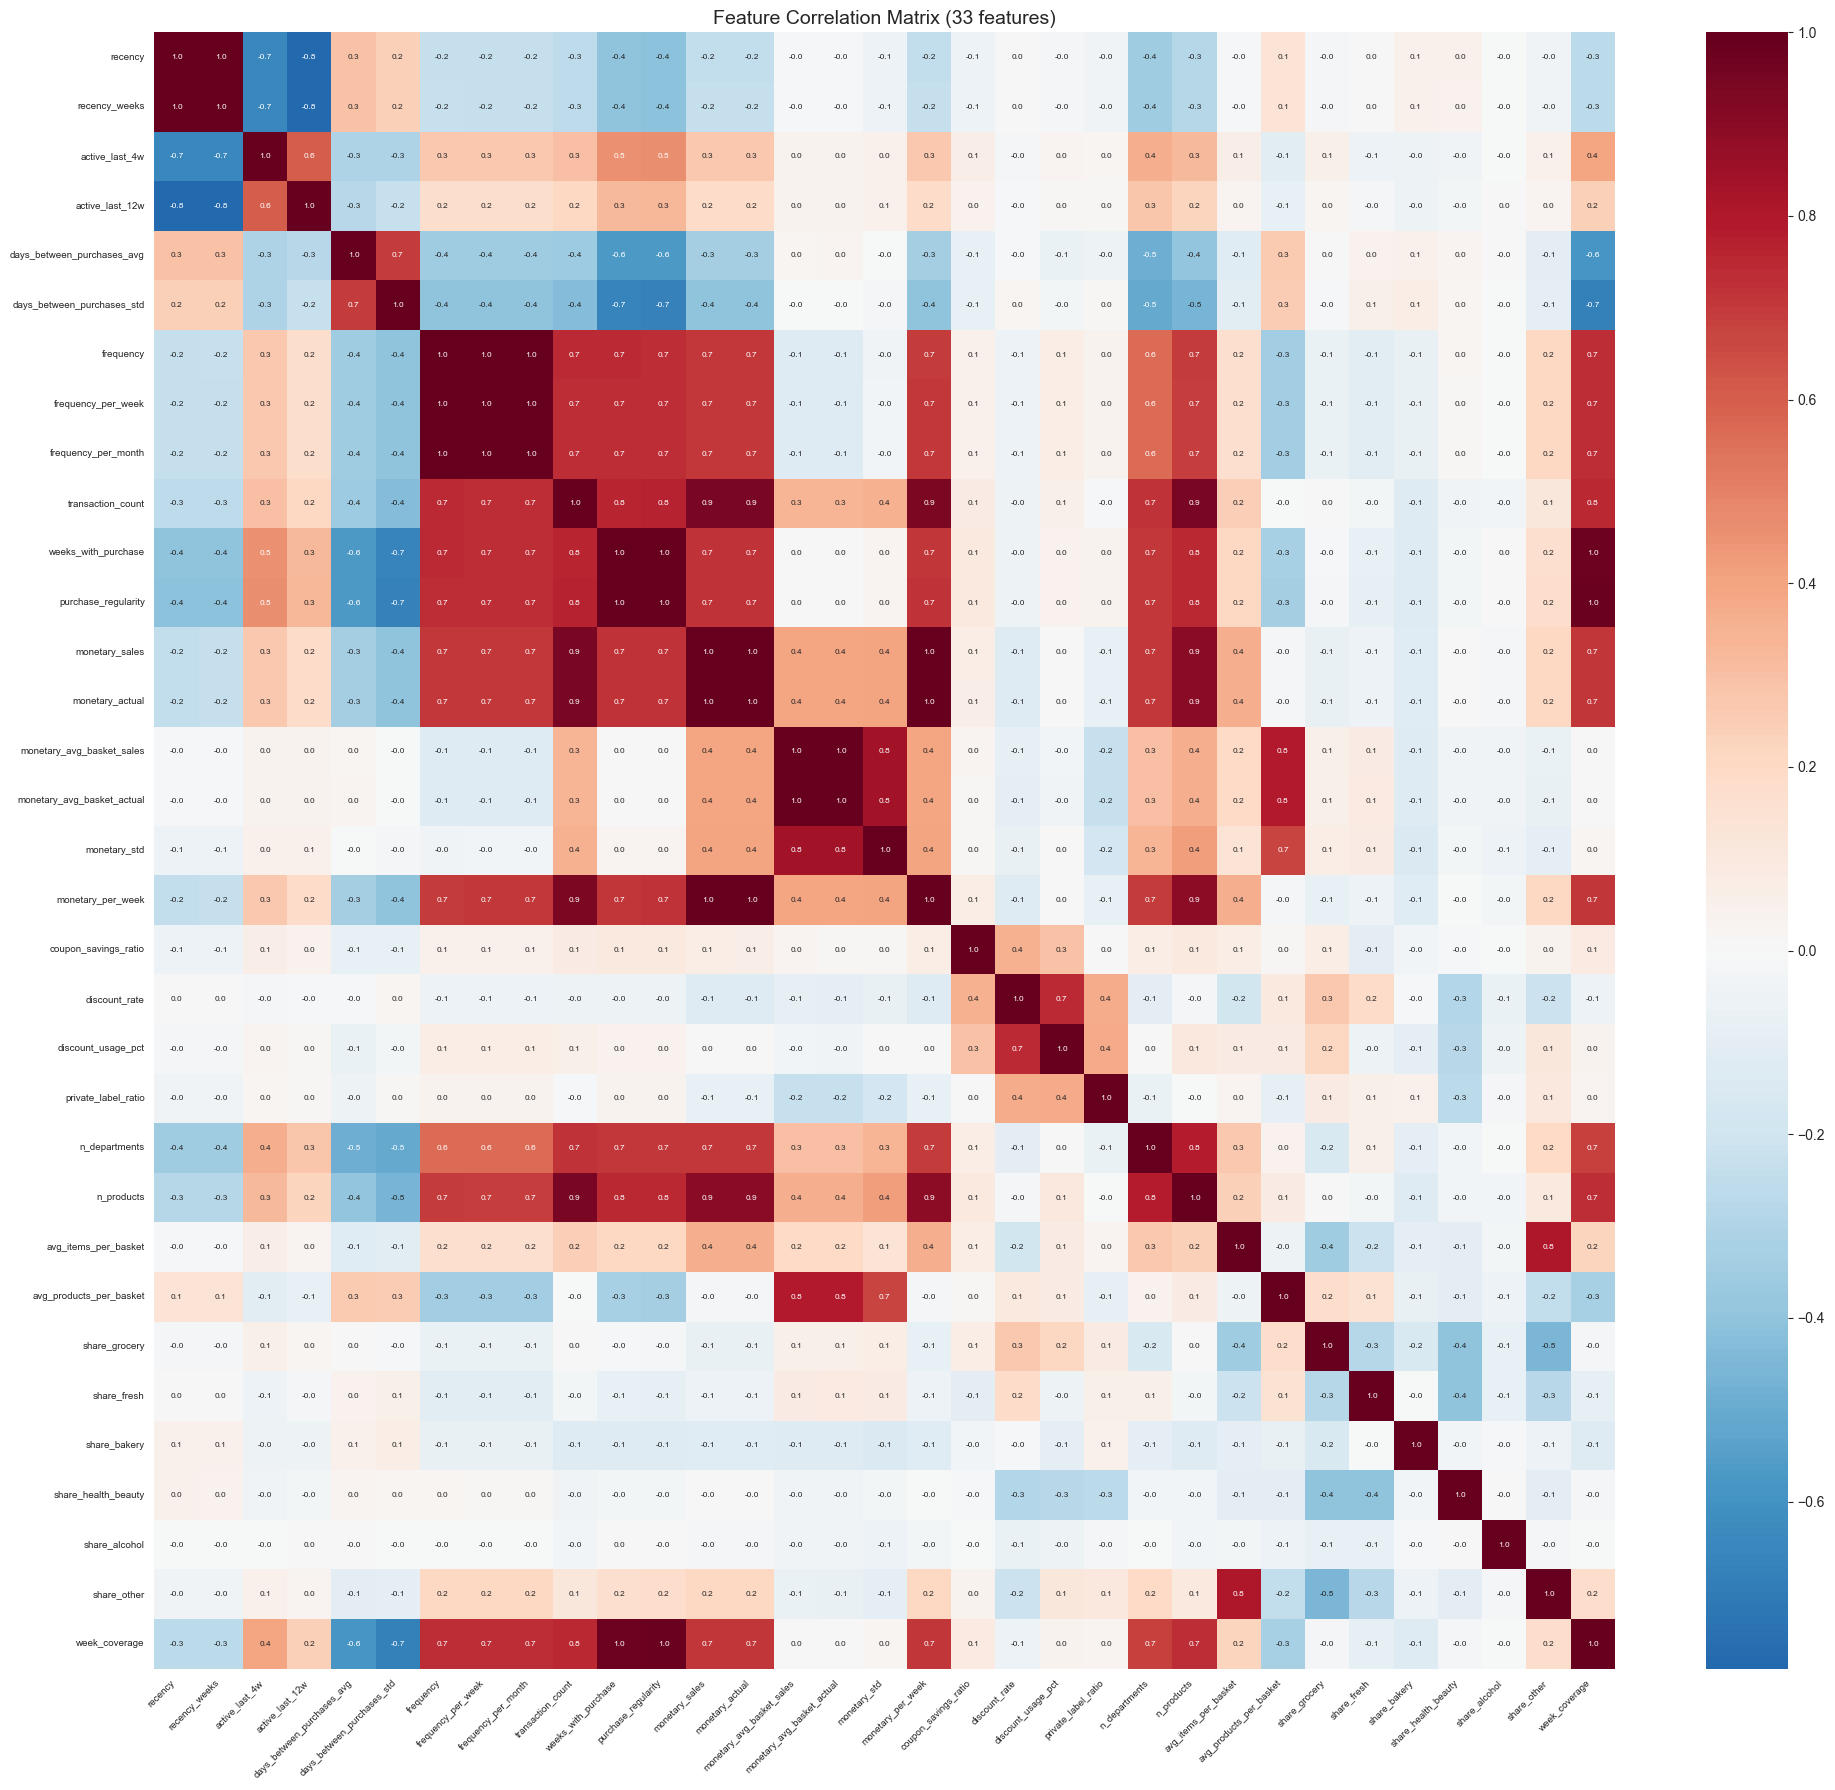

In [36]:
# Feature correlation heatmap
fig, ax = plt.subplots(figsize=(20, 18))
corr = df_features[ALL_FEATURE_COLS].corr()
sns.heatmap(corr, annot=True, fmt='.1f', cmap='RdBu_r', center=0, 
            annot_kws={'size': 6}, ax=ax)
ax.set_title(f'Feature Correlation Matrix ({len(ALL_FEATURE_COLS)} features)', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
plt.tight_layout()
plt.show()